In [3]:
library(ggplot2)
library(caret)
library(corrplot)
library(pROC)
library(class)
library(e1071)
library(rpart)
library(rpart.plot)

Warning message:
"package 'corrplot' was built under R version 3.6.3"corrplot 0.84 loaded
Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'rpart.plot' was built under R version 3.6.3"

# Credit Card Fraud Detection

## Introduction
In this kernel we will use four predictive models to see how accurately they can detect and classify a normal transaction or a fraud. As described in the dataset page, all features except "Time" and "Amount" are scaled and the names of the features are not shown due to privacy reasons. The main goal of this work is to find the best classification model out of 4. The models are loggistic regression, k-nearest neighbours, support vector machine and decision tree.

## References

Link to the data set: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Data Processing

After the dataset was downloaded let's set the working directory and read the dataset:

In [4]:
setwd("E:/Sanek/Projects/R/SoftUni/ML_exam/")

In [5]:
credit.data <- read.csv("creditcard.csv")

Let's see if the dataset was read correctly, and then familiarise with it a bit.

In [13]:
names(credit.data)

[1] "Time"   "V1"     "V2"     "V3"     "V4"     "V5"     "V6"     "V7"    
 [9] "V8"     "V9"     "V10"    "V11"    "V12"    "V13"    "V14"    "V15"   
[17] "V16"    "V17"    "V18"    "V19"    "V20"    "V21"    "V22"    "V23"   
[25] "V24"    "V25"    "V26"    "V27"    "V28"    "Amount" "Class"

In [14]:
str(credit.data)

'data.frame':	284807 obs. of  31 variables:
 $ Time  : num  0 0 1 1 2 2 4 7 7 9 ...
 $ V1    : num  -1.36 1.192 -1.358 -0.966 -1.158 ...
 $ V2    : num  -0.0728 0.2662 -1.3402 -0.1852 0.8777 ...
 $ V3    : num  2.536 0.166 1.773 1.793 1.549 ...
 $ V4    : num  1.378 0.448 0.38 -0.863 0.403 ...
 $ V5    : num  -0.3383 0.06 -0.5032 -0.0103 -0.4072 ...
 $ V6    : num  0.4624 -0.0824 1.8005 1.2472 0.0959 ...
 $ V7    : num  0.2396 -0.0788 0.7915 0.2376 0.5929 ...
 $ V8    : num  0.0987 0.0851 0.2477 0.3774 -0.2705 ...
 $ V9    : num  0.364 -0.255 -1.515 -1.387 0.818 ...
 $ V10   : num  0.0908 -0.167 0.2076 -0.055 0.7531 ...
 $ V11   : num  -0.552 1.613 0.625 -0.226 -0.823 ...
 $ V12   : num  -0.6178 1.0652 0.0661 0.1782 0.5382 ...
 $ V13   : num  -0.991 0.489 0.717 0.508 1.346 ...
 $ V14   : num  -0.311 -0.144 -0.166 -0.288 -1.12 ...
 $ V15   : num  1.468 0.636 2.346 -0.631 0.175 ...
 $ V16   : num  -0.47 0.464 -2.89 -1.06 -0.451 ...
 $ V17   : num  0.208 -0.115 1.11 -0.684 -0.237 ...
 $ V

In [15]:
sum(is.na(credit.data))

[1] 0

Except for the transaction and amount we don't know what the other columns are. The only thing we know, is that those columns, that are unknown, have already been scaled. Time is a linearly increasing vector, so we should exclude it from our analysis. Amount is a numeric variable, so in order to analyse it we need to normalise it as well.

In [6]:
credit.data$norm.amount <- scale(credit.data$Amount)
credit.data <- credit.data[,c(-1,-30)]

It is not hard to imagine that our Class variable is imbalanced, since the proportion of credit card fraud is low in our daily life.

In [5]:
summary(as.factor(credit.data$Class))

0      1 
284315    492

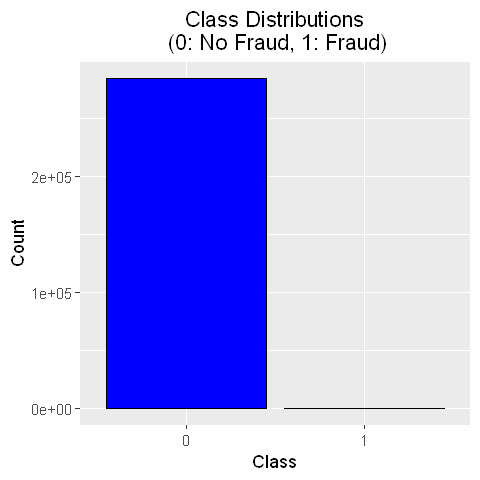

In [26]:
ggplot(data = credit.data, aes(as.factor(Class))) +
  geom_bar(color = "black", fill = c("blue", "red")) +
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("Class") +
  ylab("Count")+
  ggtitle(label = " Class Distributions \n (0: No Fraud, 1: Fraud)")

## Random Under-Sampling:

Due to the fact that our dataframe is very imbalanced we can't proceed with conducting an analysis immediately. For that reason we will implement a method named "Random Under-Sampling", which basically consists of random deleting samples from the majority class in order to equalise the number of observations to that in the minority class. Upon implementing this method, we will have a sub-sample of our dataframe with a 50/50 (492/492) ratio with regards to our classes.

In [7]:
set.seed(12345)

index <- createDataPartition(which(credit.data$Class == 0), p = 0.1, list = FALSE, times = 1)

sampled.data <- credit.data[c(index[1:492], which(credit.data$Class == 1)),]

summary(as.factor(sampled.data$Class))

0   1 
492 492

## Correlation Matrices

Correlation matrices are crucial to understanding our data, just because they can show us which variables are in any relation with Class. We want to know if there are features that strongly indicate whether a particular transaction is a fraud. 

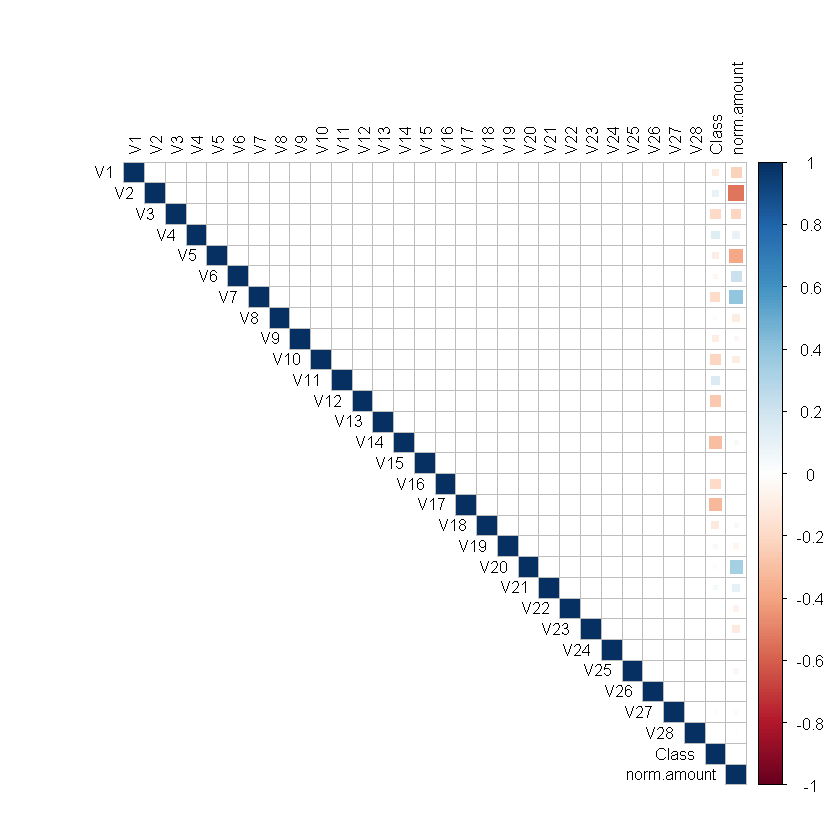

In [10]:
# Correlation matrix of imbalanced data

correlations.credit <- cor(credit.data, method="pearson")

corrplot(correlations.credit, method = "square", type = "upper",
         tl.cex=0.8, tl.col = "black")

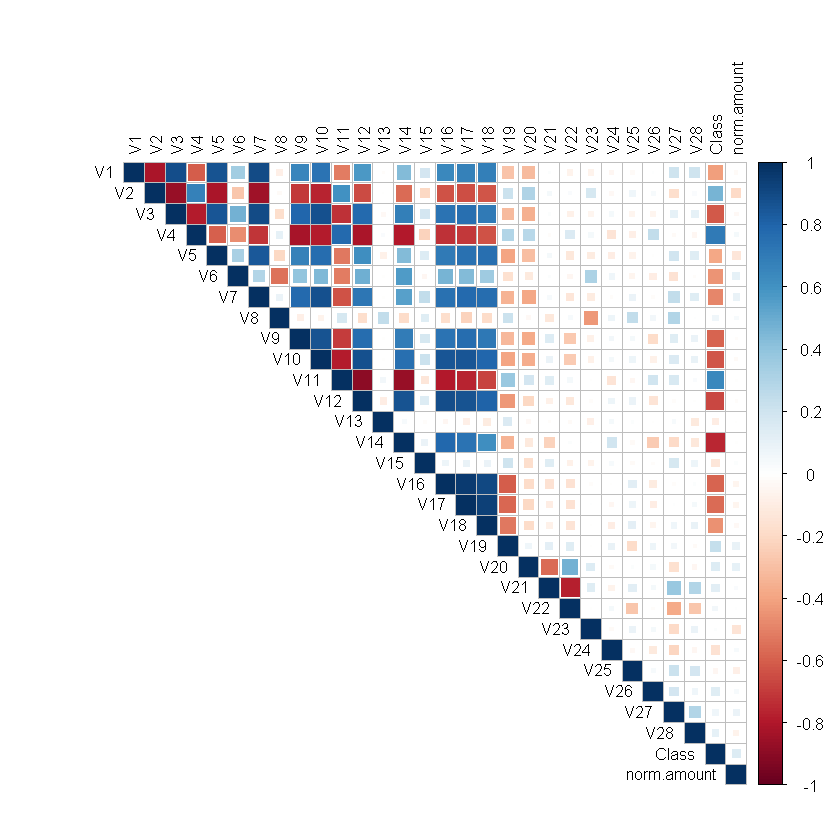

In [11]:
# Correlation matrix of sampled data

correlations.sampled <- cor(sampled.data, method="pearson")

corrplot(correlations.sampled, method = "square", type = "upper",
         tl.cex=0.8, tl.col = "black")

As we have seen, there are fewer correlations in the imbalanced data matrix and they are weaker. That is the reason why we should explain the sampled data matrix result.

Summary:

Positive Correlations: V4, V11, and V19 are positively correlated. Notice how the higher these values are (especially V4), the more likely the end result will be a fraudulent transaction.
Negative Correlations: V3, V10, V12, V14, V16 and V17  are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraudulent transaction.


## Train - test spliting
Now we can split our sampled data to train and test samples.

In [18]:
set.seed(12345)

trainIndex <- createDataPartition(sampled.data$Class, p = .8,
                                  list = FALSE,
                                  times = 1)

sampled.data.train <- sampled.data[trainIndex,]
sampled.data.test <- sampled.data[-trainIndex,]

## Data Modeling

Now we can conduct our analysis and on the basis of the highest recall score choose the best classification model.

### Logistic regression

In [19]:
log.model <- glm(Class ~ ., sampled.data.train, family = "binomial")

summary(log.model)

log.predict <- predict(log.model, newdata = sampled.data.train, type = "response") 

log.fitted.results <- ifelse(log.predict > 0.5,"1","0")

log.cm <- confusionMatrix(data=as.factor(log.fitted.results), 
                      reference = as.factor(sampled.data.train$Class))

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Class ~ ., family = "binomial", data = sampled.data.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4389  -0.1644   0.0000   0.0000   2.8162  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -9.212     29.650  -0.311    0.756
V1            18.265     67.106   0.272    0.785
V2           167.507    454.859   0.368    0.713
V3           -74.957    176.272  -0.425    0.671
V4            58.021    143.680   0.404    0.686
V5            -1.667     17.108  -0.097    0.922
V6           -76.776    206.864  -0.371    0.711
V7          -268.863    712.430  -0.377    0.706
V8            46.768    120.940   0.387    0.699
V9           -84.609    217.495  -0.389    0.697
V10         -194.293    500.004  -0.389    0.698
V11          161.189    424.467   0.380    0.704
V12         -290.720    762.329  -0.381    0.703
V13           -7.256     20.096  -0.361    0.718
V14         -315.858    832.041  -0.380    0.704
V15    

We see that all variables have a statistically insignificant effect on the target variable. This is likely due to the small sample size.

In [37]:
log.cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 388  18
         1   6 376
                                         
               Accuracy : 0.9695         
                 95% CI : (0.955, 0.9804)
    No Information Rate : 0.5            
    P-Value [Acc > NIR] : < 2e-16        
                                         
                  Kappa : 0.9391         
                                         
 Mcnemar's Test P-Value : 0.02474        
                                         
            Sensitivity : 0.9848         
            Specificity : 0.9543         
         Pos Pred Value : 0.9557         
         Neg Pred Value : 0.9843         
             Prevalence : 0.5000         
         Detection Rate : 0.4924         
   Detection Prevalence : 0.5152         
      Balanced Accuracy : 0.9695         
                                         
       'Positive' Class : 0              
                                         

For a better presentation, we can plot the ROC curve for the logistic model.

Setting levels: control = 0, case = 1
Setting direction: controls < cases


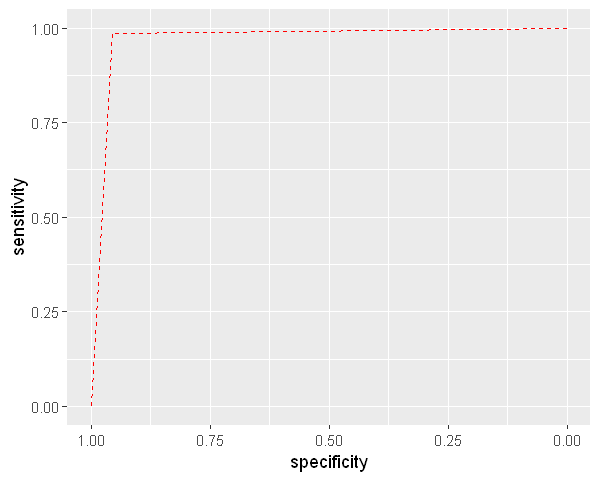

In [34]:
log.roc <- roc(log.fitted.results, sampled.data.train$Class)
ggroc(log.roc, colour = "red", linetype = 2)
options(repr.plot.width= 4, repr.plot.height=3)

### k-Nearest Neighbor

In [35]:
sampled.data.train$Class <- as.factor(sampled.data.train$Class)

set.seed(12345)

knn.model <- train(Class ~ ., data = sampled.data.train,
               method = 'knn', tuneLength = 20)

knn.model

k-Nearest Neighbors 

788 samples
 29 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 788, 788, 788, 788, 788, 788, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.9385401  0.8769925
   7  0.9376821  0.8753101
   9  0.9374715  0.8748752
  11  0.9377564  0.8754466
  13  0.9363786  0.8727002
  15  0.9360857  0.8721547
  17  0.9351094  0.8702197
  19  0.9344331  0.8688542
  21  0.9325126  0.8650294
  23  0.9311244  0.8622563
  25  0.9307131  0.8614332
  27  0.9301459  0.8603037
  29  0.9283678  0.8567401
  31  0.9282292  0.8564662
  33  0.9283797  0.8567736
  35  0.9278203  0.8556633
  37  0.9279670  0.8559478
  39  0.9275339  0.8550789
  41  0.9271422  0.8542858
  43  0.9269785  0.8539661

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

The algorithm found that k=5 as more optimal than the other number of k, let's show it.

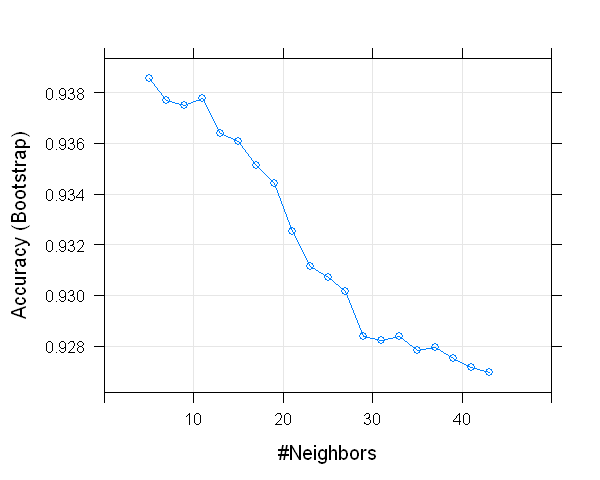

In [77]:
plot(knn.model, xlim= c(0, 50))

In [36]:
knn.predict <- predict(knn.model, newdata = sampled.data.train)

knn.cm <- confusionMatrix(data = knn.predict, 
                          reference = sampled.data.train$Class)
knn.cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 392  30
         1   2 364
                                          
               Accuracy : 0.9594          
                 95% CI : (0.9432, 0.9721)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9188          
                                          
 Mcnemar's Test P-Value : 1.815e-06       
                                          
            Sensitivity : 0.9949          
            Specificity : 0.9239          
         Pos Pred Value : 0.9289          
         Neg Pred Value : 0.9945          
             Prevalence : 0.5000          
         Detection Rate : 0.4975          
   Detection Prevalence : 0.5355          
      Balanced Accuracy : 0.9594          
                                          
       'Positive' Class : 0               
                              

After the confusion matrix was built we can plot the ROC curve for the knn model.

Setting levels: control = 0, case = 1
Setting direction: controls < cases


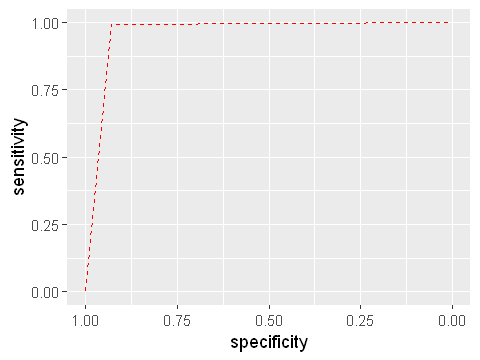

In [37]:
knn.roc <- roc(knn.predict , as.numeric(sampled.data.train$Class))
ggroc(knn.roc, colour = "red", linetype = 2)
options(repr.plot.width= 4, repr.plot.height=3)

### Support vector machine

In [38]:
svm.model <- svm(Class ~ ., data = sampled.data.train, kernel = "sigmoid", scale = FALSE)

svm.predict <- predict(svm.model, newdata = sampled.data.train)

svm.cm <- confusionMatrix(data = svm.predict, 
                          reference = sampled.data.train$Class)
svm.cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 324  69
         1  70 325
                                          
               Accuracy : 0.8236          
                 95% CI : (0.7952, 0.8496)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6472          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8223          
            Specificity : 0.8249          
         Pos Pred Value : 0.8244          
         Neg Pred Value : 0.8228          
             Prevalence : 0.5000          
         Detection Rate : 0.4112          
   Detection Prevalence : 0.4987          
      Balanced Accuracy : 0.8236          
                                          
       'Positive' Class : 0               
                              

Roc curve for the Support vector machine model:

Setting levels: control = 0, case = 1
Setting direction: controls < cases


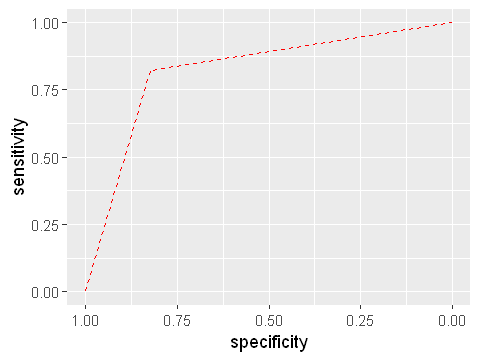

In [39]:
svm.roc <- roc(svm.predict, as.numeric(sampled.data.train$Class))
ggroc(svm.roc, colour = "red", linetype = 2)
options(repr.plot.width= 4, repr.plot.height=3)

### Decision Tree

In [40]:
dtree.model <- rpart(Class ~., data = sampled.data.train, method = 'class')

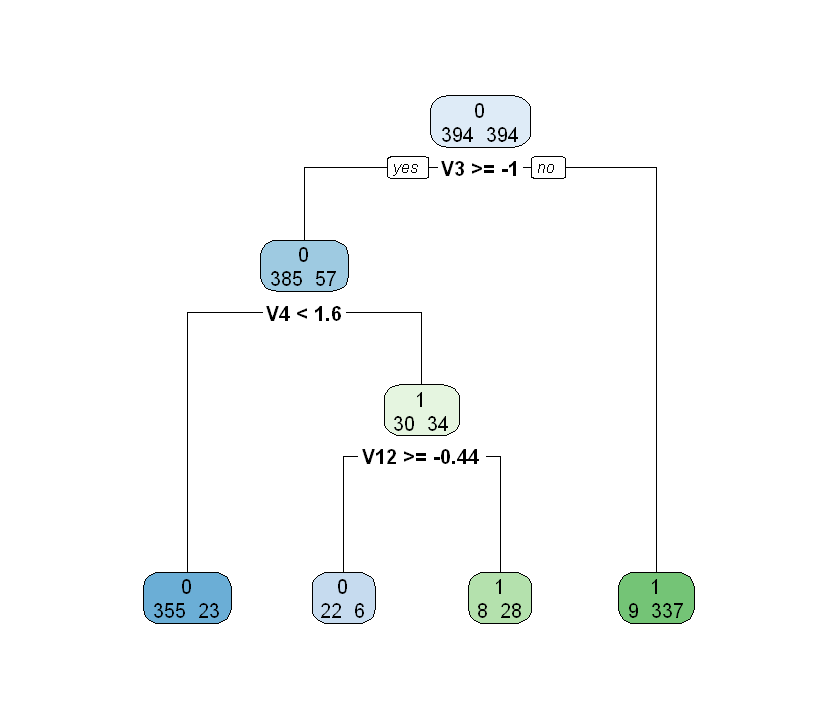

In [115]:
rpart.plot(dtree.model, extra = 1)

In [41]:
dtree.predict <- predict(dtree.model, newdata = sampled.data.train, type = "class")

dtree.cm <- confusionMatrix(data = dtree.predict, 
                          reference = sampled.data.train$Class)
dtree.cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 377  29
         1  17 365
                                          
               Accuracy : 0.9416          
                 95% CI : (0.9229, 0.9569)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8832          
                                          
 Mcnemar's Test P-Value : 0.1048          
                                          
            Sensitivity : 0.9569          
            Specificity : 0.9264          
         Pos Pred Value : 0.9286          
         Neg Pred Value : 0.9555          
             Prevalence : 0.5000          
         Detection Rate : 0.4784          
   Detection Prevalence : 0.5152          
      Balanced Accuracy : 0.9416          
                                          
       'Positive' Class : 0               
                              

Roc curve for the Decision Tree model:

Setting levels: control = 0, case = 1
Setting direction: controls < cases


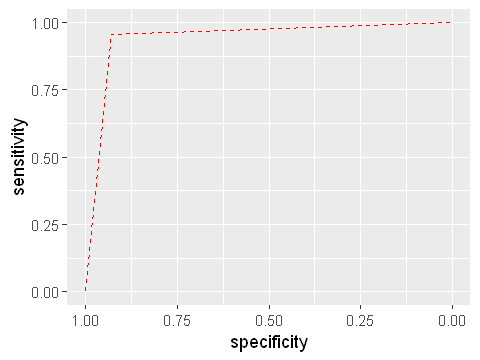

In [42]:
dtree.roc <- roc(dtree.predict, as.numeric(sampled.data.train$Class))
ggroc(dtree.roc, colour = "red", linetype = 2)
options(repr.plot.width= 4, repr.plot.height=3)

## Summary

With all of our analysis now done, we can compare their results and choose the best.

1. First, let's plot the ROC curves to get a visual presentation for a better comparison.

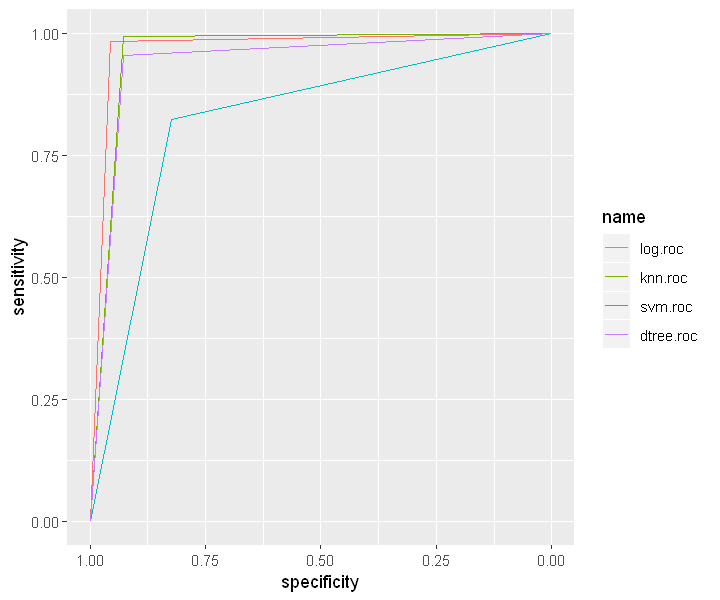

In [49]:
roc.curves <- list(log.roc = log.roc, knn.roc = knn.roc, svm.roc = svm.roc, 
                      dtree.roc = dtree.roc)

ggroc(roc.curves, linetype = 1)
options(repr.plot.width = 6, repr.plot.height = 5)

The knn.roc curve is a little bit higher than the logistic regression curve, but it's with a large slope too.

In [57]:
cat(" Recall for logistic regression is:", log.cm$byClass[[3]], 
    "\n Recall for knn is:", knn.cm$byClass[[3]],
    "\n Recall for dtree is:", dtree.cm$byClass[[3]],
    " \n Recall for suppor vector machine is:", svm.cm$byClass[[3]])

cat("\n\n Precision for logistic regression is:", log.cm$overall[[1]], 
    "\n Precision for knn is:", knn.cm$overall[[1]],
    "\n Precision for dtree is:", dtree.cm$overall[[1]],
    " \n Precision for suppor vector machine is:", svm.cm$overall[[1]])

 Recall for logistic regression is: 0.955665 
 Recall for knn is: 0.92891 
 Recall for dtree is: 0.9285714  
 Recall for suppor vector machine is: 0.8244275

 Precision for logistic regression is: 0.9695431 
 Precision for knn is: 0.9593909 
 Precision for dtree is: 0.9416244  
 Precision for suppor vector machine is: 0.8236041

So, the linear logistic model presents the best recall and precision scores. Now we can use the model to predict fraudulent transactions in the test sample.

## Test sample prediction

In [59]:
test.log.predict <- predict(log.model, newdata = sampled.data.test, type = "response") 

test.log.fitted.results <- ifelse(test.log.predict > 0.5,"1","0")

test.log.cm <- confusionMatrix(data=as.factor(test.log.fitted.results), 
                          reference = as.factor(sampled.data.test$Class))
test.log.cm

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 95  3
         1  3 95
                                          
               Accuracy : 0.9694          
                 95% CI : (0.9346, 0.9887)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9388          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9694          
            Specificity : 0.9694          
         Pos Pred Value : 0.9694          
         Neg Pred Value : 0.9694          
             Prevalence : 0.5000          
         Detection Rate : 0.4847          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.9694          
                                          
       'Positive' Class : 0               
                                    

Setting levels: control = 0, case = 1
Setting direction: controls < cases


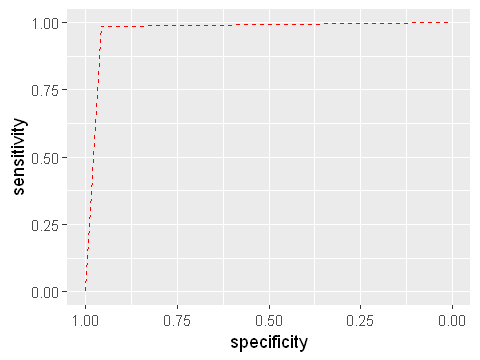

In [61]:
test.log.roc <- roc(test.log.fitted.results, sampled.data.test$Class)
ggroc(log.roc, colour = "red", linetype = 2)
options(repr.plot.width= 4, repr.plot.height=3)

In [67]:
cat(" Recall for test sample after logistic regression is:", test.log.cm$byClass[[3]], 
    "\n Precision for for test sample after logistic regression is:", test.log.cm$overall[[1]])

 Recall for test sample after logistic regression is: 0.9693878 
 Precision for for test sample after logistic regression is: 0.9693878

## Conclucion

After establishing a very large difference in the number of fraudulent and regular transactions, we conducted a random Under-Sampling to equalize the number of observations in both classes. We split the data to train and test samples, after which we conducted four analysis to find the best one in fraudulent transaction prediction. We achived our goal and found the best model based on recall score and this is the logistic model with recall 0.956. We predicted the test sample and our score is recall equal to 0.969.
The large problems with this dataset include a very imbalanced data and hidden variables names, so we cannot make any logic interpretation of the correlations and results as such. Maybe that could be a positive, but the only way we can utilise this dataset is to produce different types of analysis.